In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(os.path.join(data_dir, 'train_data.npz'))
val_data = np.load(os.path.join(data_dir, 'validation_data.npz'))
test_data = np.load(os.path.join(data_dir, 'test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 25443),
 (36805,),
 (4293, 25443),
 (4293,),
 (4815, 25443),
 (4815,),
 (16, 2))

In [6]:
def preprocess(x_data):
    x_data = np.reshape(x_data, [x_data.shape[0], 99, 257, 1])
    x_data = np.rot90(x_data, 1, (1, 2))
    return x_data

In [7]:
output_size = y_table.shape[0]

In [8]:
x_train_2d = preprocess(x_train)
mean_vals = np.mean(x_train_2d, axis=0)
std_val = np.std(x_train_2d)
x_train_2d_norm = (x_train_2d-mean_vals) / std_val
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_2d = preprocess(x_val)
x_val_2d_norm = (x_val_2d-mean_vals) / std_val
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_2d = preprocess(x_test)
x_test_2d_norm = (x_test_2d-mean_vals) / std_val
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [9]:
input_shape = x_test_2d_norm[0].shape

In [10]:
def build_cnn_bn(conv_num=1, fcn_num=1):
    model=Sequential()
    model.add(Conv2D (kernel_size=5, filters=8, strides=(1,1), padding='valid', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2, strides=(2,2), padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv2D (kernel_size=5, filters=8*(2**(i+1)), strides=(1,1), padding='valid'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=2, strides=(2,2), padding='same'))

    model.add(Flatten())
    
    for i in range(fcn_num):
        model.add(Dense(1024/(2**i)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
    
    model.add(Dense(output_size, activation='softmax' ))
    return model

Instructions for updating:
Colocations handled automatically by placer.
Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.1069 - acc: 0.6687
Epoch 00001: val_loss improved from inf to 0.77743, saving model to model/checkpoint/2D_CNN_BN_1_conv_1_fcn_checkpoint/01-0.7774.hdf5
36805/36805 [==============================] - 26s 707us/sample - loss: 1.1070 - acc: 0.6688 - val_loss: 0.7774 - val_acc: 0.7640
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.5270 - acc: 0.8472
Epoch 00002: val_loss improved from 0.77743 to 0.64580, saving model to model/checkpoint/2D_CNN_BN_1_conv_1_fcn_checkpoint/02-0.6458.hdf5
36805/36805 [==============================] - 24s 652us/sample - loss: 0.5270 - acc: 0.8471 - val_loss: 0.6458 - val_acc: 0.8069
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.3019 - acc: 0.9227
Epoch 00003

Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0076 - acc: 0.9991
Epoch 00028: val_loss did not improve from 0.62927
36805/36805 [==============================] - 23s 637us/sample - loss: 0.0076 - acc: 0.9991 - val_loss: 0.8639 - val_acc: 0.8160
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0072 - acc: 0.9988
Epoch 00029: val_loss did not improve from 0.62927
36805/36805 [==============================] - 23s 635us/sample - loss: 0.0075 - acc: 0.9987 - val_loss: 1.1227 - val_acc: 0.7834
Epoch 30/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0114 - acc: 0.9983
Epoch 00030: val_loss did not improve from 0.62927
36805/36805 [==============================] - 23s 632us/sample - loss: 0.0114 - acc: 0.9983 - val_loss: 0.9398 - val_acc: 0.8020
Epoch 31/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0060 - acc: 0.9992
Epoch 00031: val_loss did not improve from 0.62927
36805/36805 [=====

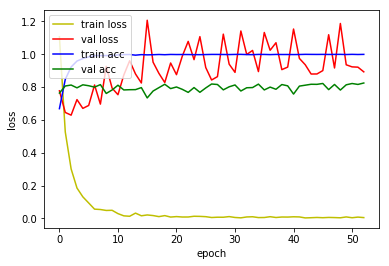

4815/4815 [==============================] - 1s 231us/sample - loss: 0.7620 - acc: 0.7790
Loss: 0.7619601072675838 Accuracy: 0.7790239

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.0520 - acc: 0.6792
Epoch 00001: val_loss improved from inf to 0.73109, saving model to model/checkpoint/2D_CNN_BN_1_conv_2_fcn_checkpoint/01-0.7311.hdf5
36805/36805 [==============================] - 26s 705us/sample - loss: 1.0520 - acc: 0.6793 - val_loss: 0.7311 - val_acc: 0.7885
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.4556 - acc: 0.8723
Epoch 00002: val_loss improved from 0.73109 to 0.61831, saving model to model/checkpoint/2D_CNN_BN_1_conv_2_fcn_checkpoint/02-0.6183.hdf5
36805/36805 [==============================] - 24s 661us/sample - loss: 0.4557 - acc: 0.8723 - val_loss: 0.6183 - val_acc: 0.8141
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.2473 - acc: 0.

Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0100 - acc: 0.9979
Epoch 00029: val_loss did not improve from 0.57122
36805/36805 [==============================] - 24s 652us/sample - loss: 0.0100 - acc: 0.9979 - val_loss: 1.0457 - val_acc: 0.7738
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0061 - acc: 0.9987
Epoch 00030: val_loss did not improve from 0.57122
36805/36805 [==============================] - 24s 650us/sample - loss: 0.0061 - acc: 0.9987 - val_loss: 0.9024 - val_acc: 0.7990
Epoch 31/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0111 - acc: 0.9971
Epoch 00031: val_loss did not improve from 0.57122
36805/36805 [==============================] - 24s 656us/sample - loss: 0.0111 - acc: 0.9971 - val_loss: 1.7724 - val_acc: 0.6804
Epoch 32/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0088 - acc: 0.9979
Epoch 00032: val_loss did not improve from 0.57122
36805/36805 [=====

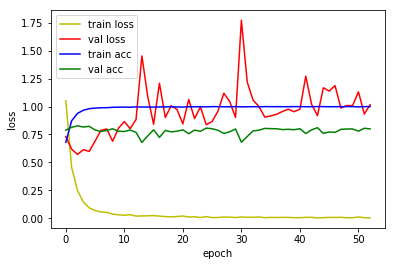

4815/4815 [==============================] - 1s 278us/sample - loss: 0.6507 - acc: 0.8000
Loss: 0.6506838228472297 Accuracy: 0.8

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.0031 - acc: 0.6997
Epoch 00001: val_loss improved from inf to 0.70711, saving model to model/checkpoint/2D_CNN_BN_2_conv_1_fcn_checkpoint/01-0.7071.hdf5
36805/36805 [==============================] - 23s 617us/sample - loss: 1.0031 - acc: 0.6997 - val_loss: 0.7071 - val_acc: 0.7934
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.4045 - acc: 0.8873
Epoch 00002: val_loss improved from 0.70711 to 0.51362, saving model to model/checkpoint/2D_CNN_BN_2_conv_1_fcn_checkpoint/02-0.5136.hdf5
36805/36805 [==============================] - 21s 569us/sample - loss: 0.4045 - acc: 0.8873 - val_loss: 0.5136 - val_acc: 0.8477
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.2151 - acc: 0.9478
E

Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0028 - acc: 0.9996
Epoch 00029: val_loss did not improve from 0.46224
36805/36805 [==============================] - 20s 541us/sample - loss: 0.0028 - acc: 0.9996 - val_loss: 0.6223 - val_acc: 0.8628
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0044 - acc: 0.9990
Epoch 00030: val_loss did not improve from 0.46224
36805/36805 [==============================] - 20s 539us/sample - loss: 0.0044 - acc: 0.9990 - val_loss: 0.8660 - val_acc: 0.8216
Epoch 31/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0121 - acc: 0.9969
Epoch 00031: val_loss did not improve from 0.46224
36805/36805 [==============================] - 20s 555us/sample - loss: 0.0121 - acc: 0.9969 - val_loss: 0.8828 - val_acc: 0.8239
Epoch 32/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0071 - acc: 0.9983
Epoch 00032: val_loss did not improve from 0.46224
36805/36805 [=====

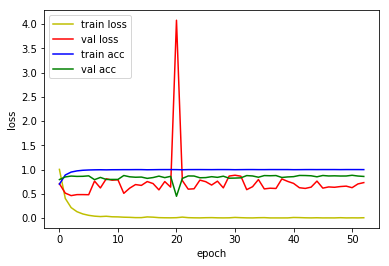

4815/4815 [==============================] - 2s 330us/sample - loss: 0.5551 - acc: 0.8363
Loss: 0.5551366732004152 Accuracy: 0.8363448

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.9903 - acc: 0.7019
Epoch 00001: val_loss improved from inf to 0.61135, saving model to model/checkpoint/2D_CNN_BN_2_conv_2_fcn_checkpoint/01-0.6113.hdf5
36805/36805 [==============================] - 25s 678us/sample - loss: 0.9903 - acc: 0.7019 - val_loss: 0.6113 - val_acc: 0.8267
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.3636 - acc: 0.9001
Epoch 00002: val_loss improved from 0.61135 to 0.55901, saving model to model/checkpoint/2D_CNN_BN_2_conv_2_fcn_checkpoint/02-0.5590.hdf5
36805/36805 [==============================] - 22s 592us/sample - loss: 0.3637 - acc: 0.9000 - val_loss: 0.5590 - val_acc: 0.8176
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1663 - acc: 0.

36800/36805 [============================>.] - ETA: 0s - loss: 0.0083 - acc: 0.9983
Epoch 00028: val_loss did not improve from 0.46573
36805/36805 [==============================] - 21s 570us/sample - loss: 0.0083 - acc: 0.9983 - val_loss: 0.7102 - val_acc: 0.8502
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0032 - acc: 0.9995
Epoch 00029: val_loss did not improve from 0.46573
36805/36805 [==============================] - 21s 563us/sample - loss: 0.0032 - acc: 0.9995 - val_loss: 0.5921 - val_acc: 0.8712
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0033 - acc: 0.9993
Epoch 00030: val_loss did not improve from 0.46573
36805/36805 [==============================] - 21s 569us/sample - loss: 0.0034 - acc: 0.9993 - val_loss: 0.7181 - val_acc: 0.8456
Epoch 31/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0095 - acc: 0.9977
Epoch 00031: val_loss did not improve from 0.46573
36805/36805 [==================

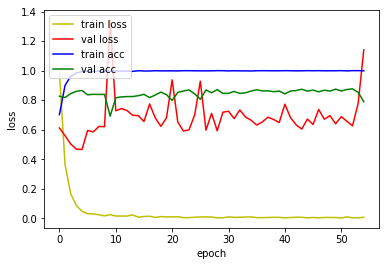

4815/4815 [==============================] - 1s 310us/sample - loss: 0.5344 - acc: 0.8336
Loss: 0.5343538728334698 Accuracy: 0.83364487

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.9719 - acc: 0.7062
Epoch 00001: val_loss improved from inf to 0.59252, saving model to model/checkpoint/2D_CNN_BN_3_conv_1_fcn_checkpoint/01-0.5925.hdf5
36805/36805 [==============================] - 24s 664us/sample - loss: 0.9719 - acc: 0.7062 - val_loss: 0.5925 - val_acc: 0.8288
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.4122 - acc: 0.8805
Epoch 00002: val_loss improved from 0.59252 to 0.41662, saving model to model/checkpoint/2D_CNN_BN_3_conv_1_fcn_checkpoint/02-0.4166.hdf5
36805/36805 [==============================] - 19s 525us/sample - loss: 0.4122 - acc: 0.8805 - val_loss: 0.4166 - val_acc: 0.8754
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.2531 - acc: 0

Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0097 - acc: 0.9976
Epoch 00028: val_loss did not improve from 0.32195
36805/36805 [==============================] - 19s 526us/sample - loss: 0.0097 - acc: 0.9976 - val_loss: 0.3945 - val_acc: 0.9103
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0085 - acc: 0.9985
Epoch 00029: val_loss did not improve from 0.32195
36805/36805 [==============================] - 19s 525us/sample - loss: 0.0086 - acc: 0.9984 - val_loss: 0.3915 - val_acc: 0.9071
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0123 - acc: 0.9974
Epoch 00030: val_loss did not improve from 0.32195
36805/36805 [==============================] - 20s 531us/sample - loss: 0.0123 - acc: 0.9974 - val_loss: 0.3875 - val_acc: 0.9080
Epoch 31/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0057 - acc: 0.9991
Epoch 00031: val_loss did not improve from 0.32195
36805/36805 [=====


2D_CNN_BN_3_conv_1_fcn Model


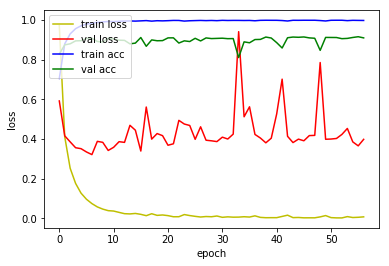

4815/4815 [==============================] - 2s 359us/sample - loss: 0.3969 - acc: 0.8883
Loss: 0.39685926800081167 Accuracy: 0.88826585

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.9479 - acc: 0.7146
Epoch 00001: val_loss improved from inf to 0.51527, saving model to model/checkpoint/2D_CNN_BN_3_conv_2_fcn_checkpoint/01-0.5153.hdf5
36805/36805 [==============================] - 28s 757us/sample - loss: 0.9480 - acc: 0.7146 - val_loss: 0.5153 - val_acc: 0.8530
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.3678 - acc: 0.8960
Epoch 00002: val_loss improved from 0.51527 to 0.35903, saving model to model/checkpoint/2D_CNN_BN_3_conv_2_fcn_checkpoint/02-0.3590.hdf5
36805/36805 [==============================] - 20s 549us/sample - loss: 0.3679 - acc: 0.8960 - val_loss: 0.3590 - val_acc: 0.8968
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.2076 - acc: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0087 - acc: 0.9981
Epoch 00028: val_loss did not improve from 0.26773
36805/36805 [==============================] - 19s 529us/sample - loss: 0.0087 - acc: 0.9981 - val_loss: 0.3382 - val_acc: 0.9234
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0061 - acc: 0.9985
Epoch 00029: val_loss did not improve from 0.26773
36805/36805 [==============================] - 19s 528us/sample - loss: 0.0061 - acc: 0.9985 - val_loss: 0.4145 - val_acc: 0.9071
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0061 - acc: 0.9987
Epoch 00030: val_loss did not improve from 0.26773
36805/36805 [==============================] - 20s 547us/sample - loss: 0.0061 - acc: 0.9987 - val_loss: 0.3780 - val_acc: 0.9150
Epoch 31/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0055 - acc: 0.9987
Epoch 00031: val_loss did not improve from 0.26773
36805/36805 [==================

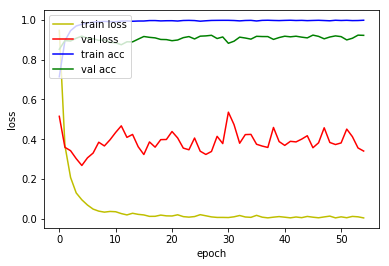

4815/4815 [==============================] - 1s 309us/sample - loss: 0.3466 - acc: 0.8883
Loss: 0.3466482015289869 Accuracy: 0.88826585

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.1009 - acc: 0.6644
Epoch 00001: val_loss improved from inf to 0.61521, saving model to model/checkpoint/2D_CNN_BN_4_conv_1_fcn_checkpoint/01-0.6152.hdf5
36805/36805 [==============================] - 26s 697us/sample - loss: 1.1010 - acc: 0.6644 - val_loss: 0.6152 - val_acc: 0.8195
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.4806 - acc: 0.8585
Epoch 00002: val_loss improved from 0.61521 to 0.37971, saving model to model/checkpoint/2D_CNN_BN_4_conv_1_fcn_checkpoint/02-0.3797.hdf5
36805/36805 [==============================] - 18s 480us/sample - loss: 0.4806 - acc: 0.8585 - val_loss: 0.3797 - val_acc: 0.8905
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.3265 - acc: 0

Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0199 - acc: 0.9951
Epoch 00028: val_loss did not improve from 0.23913
36805/36805 [==============================] - 17s 467us/sample - loss: 0.0199 - acc: 0.9951 - val_loss: 0.4503 - val_acc: 0.9003
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0136 - acc: 0.9971
Epoch 00029: val_loss did not improve from 0.23913
36805/36805 [==============================] - 17s 463us/sample - loss: 0.0136 - acc: 0.9971 - val_loss: 0.2786 - val_acc: 0.9366
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0125 - acc: 0.9972
Epoch 00030: val_loss did not improve from 0.23913
36805/36805 [==============================] - 17s 457us/sample - loss: 0.0126 - acc: 0.9972 - val_loss: 0.4042 - val_acc: 0.9071
Epoch 31/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0219 - acc: 0.9942
Epoch 00031: val_loss did not improve from 0.23913
36805/36805 [=====

Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0094 - acc: 0.9977
Epoch 00058: val_loss did not improve from 0.23913
36805/36805 [==============================] - 17s 457us/sample - loss: 0.0096 - acc: 0.9977 - val_loss: 0.2793 - val_acc: 0.9429
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0117 - acc: 0.9972
Epoch 00059: val_loss did not improve from 0.23913
36805/36805 [==============================] - 17s 460us/sample - loss: 0.0117 - acc: 0.9972 - val_loss: 0.2760 - val_acc: 0.9392
Epoch 60/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0046 - acc: 0.9992
Epoch 00060: val_loss did not improve from 0.23913
36805/36805 [==============================] - 17s 455us/sample - loss: 0.0048 - acc: 0.9992 - val_loss: 0.2814 - val_acc: 0.9413
Epoch 61/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0114 - acc: 0.9970
Epoch 00061: val_loss did not improve from 0.23913
36805/36805 [=====

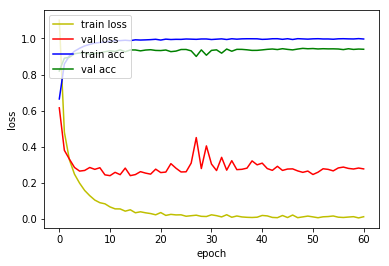

4815/4815 [==============================] - 2s 373us/sample - loss: 0.3193 - acc: 0.9049
Loss: 0.31930696194912167 Accuracy: 0.9048806

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.0723 - acc: 0.6704
Epoch 00001: val_loss improved from inf to 0.56193, saving model to model/checkpoint/2D_CNN_BN_4_conv_2_fcn_checkpoint/01-0.5619.hdf5
36805/36805 [==============================] - 29s 791us/sample - loss: 1.0723 - acc: 0.6704 - val_loss: 0.5619 - val_acc: 0.8353
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.4541 - acc: 0.8649
Epoch 00002: val_loss improved from 0.56193 to 0.36890, saving model to model/checkpoint/2D_CNN_BN_4_conv_2_fcn_checkpoint/02-0.3689.hdf5
36805/36805 [==============================] - 19s 514us/sample - loss: 0.4541 - acc: 0.8649 - val_loss: 0.3689 - val_acc: 0.8852
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.2993 - acc: 0

Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0126 - acc: 0.9970
Epoch 00028: val_loss did not improve from 0.23885
36805/36805 [==============================] - 19s 504us/sample - loss: 0.0126 - acc: 0.9970 - val_loss: 0.2675 - val_acc: 0.9376
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0204 - acc: 0.9944
Epoch 00029: val_loss did not improve from 0.23885
36805/36805 [==============================] - 18s 500us/sample - loss: 0.0204 - acc: 0.9944 - val_loss: 0.2694 - val_acc: 0.9341
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0208 - acc: 0.9943
Epoch 00030: val_loss did not improve from 0.23885
36805/36805 [==============================] - 18s 499us/sample - loss: 0.0208 - acc: 0.9943 - val_loss: 0.2712 - val_acc: 0.9352
Epoch 31/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0094 - acc: 0.9980
Epoch 00031: val_loss did not improve from 0.23885
36805/36805 [=====


2D_CNN_BN_4_conv_2_fcn Model


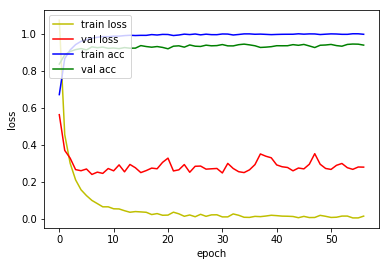

4815/4815 [==============================] - 2s 392us/sample - loss: 0.3154 - acc: 0.9013
Loss: 0.31538471353635855 Accuracy: 0.90134996



In [11]:
for i in range(1, 5):
    for j in range(1, 3):
        model_name = '2D_CNN_BN_{}_conv_{}_fcn'.format(i, j)
        model = build_cnn_bn(conv_num=i, fcn_num=j)
#         model.summary()
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])
    
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'.format(i, j)
        os.makedirs(model_path, exist_ok=True)
        model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
        checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                       verbose=1, save_best_only=True)

        early_stopping = EarlyStopping(monitor='val_loss', patience=50)
        hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=200, 
                         validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                         callbacks = [checkpointer, early_stopping])

        print()
        print(model_name, 'Model'.format(i, j))
        fig, ax = plt.subplots()
        ax.plot(hist.history['loss'], 'y', label='train loss')
        ax.plot(hist.history['val_loss'], 'r', label='val loss')
        ax.plot(hist.history['acc'], 'b', label='train acc')
        ax.plot(hist.history['val_acc'], 'g', label='val acc')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(loc='upper left')
        plt.show()
        
        png_path = 'visualization/learning_curve/'
        filename = model_name+'.png'
        os.makedirs(png_path, exist_ok=True)
        fig.savefig(png_path+filename, transparent=True)
        
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]
        model = load_model(model_filename)
        [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)
        print()
        
        del(model)

In [12]:
for i in range(1, 5):
    for j in range(1, 3):
        model_name = '2D_CNN_BN_{}_conv_{}_fcn'.format(i, j)
        print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'
  
        model = load_model(model_filename)
        model.summary()
    
        [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)
        print()
        
        del(model)

2D_CNN_BN_1_conv_1_fcn Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 253, 95, 8)        208       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 253, 95, 8)        32        
_________________________________________________________________
activation (Activation)      (None, 253, 95, 8)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 48, 8)        0         
_________________________________________________________________
flatten (Flatten)            (None, 48768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              49939456  
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 1024)      

4815/4815 [==============================] - 2s 417us/sample - loss: 0.5344 - acc: 0.8336
Loss: 0.5343538728334698 Accuracy: 0.83364487

2D_CNN_BN_3_conv_1_fcn Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 253, 95, 8)        208       
_________________________________________________________________
batch_normalization_v1_12 (B (None, 253, 95, 8)        32        
_________________________________________________________________
activation_12 (Activation)   (None, 253, 95, 8)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 48, 8)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 123, 44, 16)       3216      
_________________________________________________________________
batch_normalization_v1_13 (B (None, 123, 4

4815/4815 [==============================] - 2s 511us/sample - loss: 0.3193 - acc: 0.9049
Loss: 0.31930696194912167 Accuracy: 0.9048806

2D_CNN_BN_4_conv_2_fcn Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 253, 95, 8)        208       
_________________________________________________________________
batch_normalization_v1_26 (B (None, 253, 95, 8)        32        
_________________________________________________________________
activation_26 (Activation)   (None, 253, 95, 8)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 127, 48, 8)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 123, 44, 16)       3216      
_________________________________________________________________
batch_normalization_v1_27 (B (None, 123, 4